# Imports and Setup

Import necessary tools and modules from other files.

Before running this notebook, make sure that all the dependencies listed in __dependencies.txt__ are installed. We have included the install command for two packages that are unlikely to be installed

In [1]:
!pip install sacrebleu
!pip install seaborn
!pip install python-Levenshtein

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset, random_split
from collections import Counter
from typing import Optional, Tuple, Dict, List, Union
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import Levenshtein

from model.tokenizer import CharacterTokenizer
from data.data_readers import cognet_reader, ipa_lookup_reader, convert_to_ipa
from data.datasets import TranslationData, Direct
from model.decoder import TransformerModel, NewInstance

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Only load data during first run of the notebook. Data will be restored faster even after restarting kernel.

The preprocessing and data exrtraction may take a while. Loading and storing the variables avoids having to rerun every time the kernel is restarted.

In [4]:
try:
    %store -r de_nl_cognates
    %store -r en_de_cognates
    %store -r germanic_ipa_lookup
    de_nl_cognates, en_de_cognates, germanic_ipa_lookup
except:
    de_nl_cognates = cognet_reader("deu", "nld")
    en_de_cognates = cognet_reader("deu", "eng")
    germanic_ipa_lookup = ipa_lookup_reader()
    %store germanic_ipa_lookup
    %store de_nl_cognates
    %store en_de_cognates

### Convert all cognates to their IPA transliteration.

__Select different languages in arguments__

This extracts cognates from the Germanic languages only!

"de" for German

"en" for English

"nl" for Dutch

"sv" for Swedish

In [5]:
print("### Cognates English-German\n")
en_de_ipa_cognates = convert_to_ipa(en_de_cognates, germanic_ipa_lookup, "en", "de")

print("\n### Cognates German-Dutch\n")
nl_de_ipa_cognates = convert_to_ipa(de_nl_cognates, germanic_ipa_lookup, "nl", "de")

### Cognates English-German

IPA Transliteration complete.

Remaining cognates: 5770

### Cognates German-Dutch

IPA Transliteration complete.

Remaining cognates: 5108


This tool can be used to look up the IPA transliteration of any word in the table.

In [6]:
germanic_ipa_lookup["en"]["attempt"]

'ətɛmpt'

__Pick the data you would like to run. Let's choose Dutch–German__

In [7]:
germanic_ipa_cognates = nl_de_ipa_cognates
# germanic_ipa_cognates = en_de_ipa_cognates

### Initialize Tokenizer

In [8]:
# Define max sequence length and initialize tokenizer

MAX_SEQ_LEN = 30
all_chars = ["".join(x + y) for x, y in germanic_ipa_cognates]
tokenizer = CharacterTokenizer(all_chars, MAX_SEQ_LEN)

#Make sure all cognates are within the MAX_SEQ_LEN range
germanic_ipa_cognates = [[a[:MAX_SEQ_LEN], b[:MAX_SEQ_LEN]] for a, b in germanic_ipa_cognates]

### Romance languages

We can skip this section for now, since we've already chosen Dutch-German. Running these cells won't cause any issues though!

In [9]:
# Extract Spanish and Italian Cognates from data from Fourrier et al. 2021

es = []
with open('data/cognate_data/es_it.es', 'r') as file:
    for line in file:
        es.append(line)     

it = []
with open('data/cognate_data/es_it.it', 'r') as file:
    for line in file:
        it.append(line)

es = [string.replace(" ", "").replace(":", "")[:-1] for string in es]
it = [string.replace(" ", "").replace(":", "")[:-1] for string in it]

es_it = list(zip(es, it))
es_it = [[a[:MAX_SEQ_LEN], b[:MAX_SEQ_LEN]] for a, b in es_it]

If you want to run on Romance languages instead, make ROMANCE true to initialize the tokenizer for the Spanish-Italian condition

In [10]:
ROMANCE = False

if ROMANCE:
    MAX_SEQ_LEN = 20
    all_chars = ["".join(x + y) for x, y in es_it]
    tokenizer = CharacterTokenizer(all_chars, MAX_SEQ_LEN)

### Initializing a Model

In [11]:
config = {
    "tokenizer": tokenizer,
    "vocab_size": tokenizer.vocab_size,
    "max_len": tokenizer.max_length,
    "d_model": 128,
    "num_heads": 8,
    "attn_pdrop": 0.2,
    "dropout": 0.2,
    "d_ff": 256,
    "num_layers": 8,
    "eps": 1e-6
}

In [12]:
model = NewInstance(config)

## Create Dataset

Create dataloaders for training, validation and testing purposes. Change the argument to run on different data.

In [13]:
train_dataloader, val_dataloader, test_dataloader = Direct(tokenizer, germanic_ipa_cognates[:5000], 100, 200, 100, False)


    Created Dataset
    
    Size: 5000
    Batch: 100
    Train: 4700 Instances
    Val:   200 Instances
    Test:  100 Instances
    
    INPUT TENSOR:		TARGET TENSOR:		SEP INDEX

    Tensor(nam)		Tensor(namə)	

    


This is what the data now looks like. Note that it is already tokenized and the values printed here are the tokenizers decodings.

In [14]:
for i in range(5):
    a, b = next(iter(train_dataloader))
    print(tokenizer.decode(a[i]), tokenizer.decode(b[i]))

mnemonik mnemotɛçnɪk
bœyzərt bʊsaʁt
sxɛrpsxʉtər ʃaʁfʃʏtsə
vorɣrɔnt fɔʁdɐɡʁʊnt
ʒɑnrə ʒɑʁə


__Currently the model only outputs random strings.__

In [15]:
model.to(device)
print(tokenizer.decode(torch.argmax(model(tokenizer(["ɑspɛkt"]).to(device)), dim=-1)))

['zɪʃ<ʉɣrlʁwrøøʤøllldləøʏøadll']


# Evaluation Metrics

In [16]:
import sacrebleu
import re

def bleu(list_a, list_b, average=True, extract=False):
    
    def extract_prediction(string, alt):
        extracted = re.findall(r'\|([^|>]*)>', string)
        extracted = re.findall(r'\|([^|>]*)', string)
        if not extracted:
            extracted = alt
        else:
            extracted = extracted[0]
        return extracted
        
    if extract:
        list_a = [extract_prediction(x, "A") for x in list_a]
        list_b = [extract_prediction(x, "B") for x in list_b]
        
    score = 0
    count = 0
    for a, b in zip(list_a, list_b):
        score += sacrebleu.sentence_bleu(a, [b], tokenize='char').score
        count += 1
    if average:
        score /= count
    return score

This is the implementation for our CheatBLEU score

In [17]:
def best_bleu_selection(inputs, targets, k):
    predictions = []
    for input, target in zip(inputs, targets):
        
        logits = model.forward(tokenizer([input]).to(device), None, None)
        probabilities = F.softmax(logits, dim=-1)
        top_values, top_indeces = torch.topk(logits, k, dim=-1)    
        predicted_string = [top_indeces[0][i][0] for i in range(MAX_SEQ_LEN)]
        best_string = predicted_string
        best_bleu = bleu([tokenizer.decode(torch.stack(best_string))], [target])

        for i in range(MAX_SEQ_LEN):
            for j in range(k):
                new_string = best_string.copy()
                new_string[i] = top_indeces[0][i][j]
                new_bleu = bleu([tokenizer.decode(torch.stack(new_string))], [target])
                if new_bleu > best_bleu:
                    best_string = new_string
                    best_bleu = new_bleu
        predicted_string = tokenizer.decode(torch.stack(best_string))
        predictions.append(predicted_string)
    return predictions

# Training Loop

In [18]:
def training_loop(train_dataloader):
    
    model.train()
    
    train_loss = 0
    instances = 0
 
    with tqdm_notebook(train_dataloader, desc='Training', unit='batch', leave=False) as t:
        for input_tensor, target_tensor in t:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            batch_size = input_tensor.shape[0]
            instances += batch_size

            optimizer.zero_grad()

            logits = model(input_tensor, None)
            targets = F.one_hot(target_tensor.to(torch.long), tokenizer.vocab_size).to(torch.float)

            loss = criterion(logits, targets)
            train_loss += loss * batch_size

            loss.backward()
            optimizer.step()

            del input_tensor, target_tensor
        
    return train_loss / instances


In [19]:
def validation_loop(val_dataloader):
    
    model.eval()
    
    val_loss = 0
    bleu_scores = 0
    cheat_scores = 0
    instances = 0

    with tqdm_notebook(val_dataloader, desc='Validating', unit='batch', leave=False) as t:
        for input_tensor, target_tensor in t:
            
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)
            
            batch_size = input_tensor.shape[0]
            instances += batch_size
            
            logits = model(input_tensor, None)
            targets = F.one_hot(target_tensor.to(torch.long), tokenizer.vocab_size).to(torch.float).to(device)
            
            prediction = tokenizer.decode(torch.argmax(logits, dim=-1))
            ground_truth = tokenizer.decode(target_tensor)  
            
            best_bleu_generations = best_bleu_selection(tokenizer.decode(input_tensor.to('cpu')), ground_truth, 4)
            
            loss = criterion(logits, targets)
            val_loss += loss * batch_size
            bleu_scores += bleu(prediction, ground_truth, average=False, extract=False)
            cheat_scores += bleu(best_bleu_generations, ground_truth, average=False, extract=False)
            a = input_tensor[0]
            del input_tensor, target_tensor
            
        val_loss /= instances
        bleu_scores /= instances
        cheat_scores /= instances
        print(f"Input: {tokenizer.decode(a)},\tTarget: {ground_truth[0]},\tPredicted: {prediction[0]}")     
    return (val_loss, bleu_scores, cheat_scores)   
    

### Initilize a new model and train!

Specify the configuraton of the model

In [20]:
if model:
    del model

config = {
    "tokenizer": tokenizer,
    "vocab_size": tokenizer.vocab_size,
    "max_len": tokenizer.max_length,
    "d_model": 32,
    "num_heads": 4,
    "attn_pdrop": 0.4,
    "dropout": 0.4,
    "d_ff": 64,
    "num_layers": 4,
    "eps": 1e-6
}

model = NewInstance(config)

Train the model!

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

EPOCH #1	

Training:   0%|          | 0/47 [00:00<?, ?batch/s]

Training Loss: 1.7808


Validating:   0%|          | 0/2 [00:00<?, ?batch/s]

Input: bəsmørə,	Target: bəʃmʊtsn,	Predicted: bəbmoʁə
Validation Loss: 1.6693
Validation BLEU: 24.05658544530729
Cheating BLEU: 37.728370053688735
Epoch is complete.


EPOCH #2	

Training:   0%|          | 0/47 [00:00<?, ?batch/s]

Training Loss: 1.6431


Validating:   0%|          | 0/2 [00:00<?, ?batch/s]

Input: œytrɛkə,	Target: ʃtʁɛkn,	Predicted: autʁɛkə
Validation Loss: 1.6106
Validation BLEU: 38.70608697427562
Cheating BLEU: 58.152109748935075
Epoch is complete.


EPOCH #3	

Training:   0%|          | 0/47 [00:00<?, ?batch/s]

Training Loss: 1.6055


Validating:   0%|          | 0/2 [00:00<?, ?batch/s]

Input: xɛisər,	Target: ɡaɪziɐ,	Predicted: ɡɛisəʁ
Validation Loss: 1.5912
Validation BLEU: 42.174075534517144
Cheating BLEU: 62.672277288669086
Epoch is complete.


EPOCH #4	

Training:   0%|          | 0/47 [00:00<?, ?batch/s]

Training Loss: 1.589


Validating:   0%|          | 0/2 [00:00<?, ?batch/s]

Input: xɑndər,	Target: ɡanzɐ,	Predicted: ɡandəʁə
Validation Loss: 1.5796
Validation BLEU: 40.536476533439945
Cheating BLEU: 64.97180623412059
Epoch is complete.


EPOCH #5	

Training:   0%|          | 0/47 [00:00<?, ?batch/s]

Training Loss: 1.5796


Validating:   0%|          | 0/2 [00:00<?, ?batch/s]

Input: ɑpostrɔf,	Target: apostʁof,	Predicted: apoztʁoʊ
Validation Loss: 1.5724
Validation BLEU: 38.089059407054116
Cheating BLEU: 67.00740483156173
Epoch is complete.


EPOCH #6	

Training:   0%|          | 0/47 [00:00<?, ?batch/s]

Training Loss: 1.5735


Validating:   0%|          | 0/2 [00:00<?, ?batch/s]

Input: spɛrma,	Target: zamən,	Predicted: zpɛʁmaə
Validation Loss: 1.568
Validation BLEU: 38.037760806213235
Cheating BLEU: 67.84178811354288
Epoch is complete.


EPOCH #7	

Training:   0%|          | 0/47 [00:00<?, ?batch/s]

Training Loss: 1.5688


Validating:   0%|          | 0/2 [00:00<?, ?batch/s]

Input: knaɣə,	Target: naɡn,	Predicted: knaɡə
Validation Loss: 1.5664
Validation BLEU: 43.41394439081659
Cheating BLEU: 70.60191994283947
Epoch is complete.


EPOCH #8	

Training:   0%|          | 0/47 [00:00<?, ?batch/s]

Training Loss: 1.5659


Validating:   0%|          | 0/2 [00:00<?, ?batch/s]

Input: votʉm,	Target: votʊm,	Predicted: votʊm
Validation Loss: 1.5625
Validation BLEU: 41.91806456036451
Cheating BLEU: 71.49619921605291
Epoch is complete.


EPOCH #9	

Training:   0%|          | 0/47 [00:00<?, ?batch/s]

Training Loss: 1.5626


Validating:   0%|          | 0/2 [00:00<?, ?batch/s]

Input: medikamɛnt,	Target: medikamɛnt,	Predicted: medikamɛnt
Validation Loss: 1.5598
Validation BLEU: 40.5874654459458
Cheating BLEU: 71.75985205869361
Epoch is complete.


EPOCH #10	

Training:   0%|          | 0/47 [00:00<?, ?batch/s]

Training Loss: 1.5604


Validating:   0%|          | 0/2 [00:00<?, ?batch/s]

Input: stɪkə,	Target: ɛɐʃtɪkn,	Predicted: ztɪkəə
Validation Loss: 1.5571
Validation BLEU: 41.71663044158484
Cheating BLEU: 72.0659705308885
Epoch is complete.




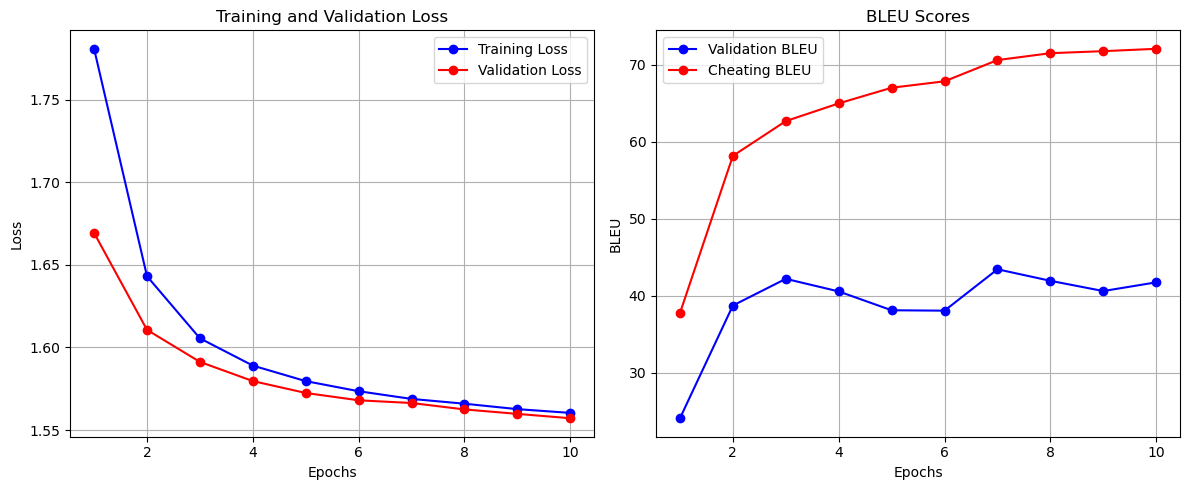

In [21]:
import matplotlib.pyplot as plt

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.075)

EPOCHS = 10

train_loss = []
val_loss =[]
train_bleu = []
val_bleu = []
cheat_bleu = []

with tqdm_notebook(range(EPOCHS), desc="Epochs") as epochs:
    for epoch in epochs:

        print(f"EPOCH #{epoch+1}", end="\t")

        training_loss = training_loop(train_dataloader)
        
        print(f"Training Loss: {round(training_loss.item(), 4)}")
        
        validation_loss, validation_bleu, cheating_bleu = validation_loop(val_dataloader)
        
        print(f"Validation Loss: {round(validation_loss.item(), 4)}")
        print(f"Validation BLEU: {validation_bleu}")
        print(f"Cheating BLEU: {cheating_bleu}")
        print("Epoch is complete.\n\n")
        
        val_loss.append(validation_loss.item())
        val_bleu.append(validation_bleu)
        cheat_bleu.append(cheating_bleu)
        
        train_loss.append(training_loss.item())
        
epochs = range(1, len(train_loss) + 1)
epoch_interval = int(len(train_loss)//len(val_loss))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

validation_epochs = range(epoch_interval, len(train_loss) + 1, epoch_interval)

axs[0].plot(epochs, train_loss, 'bo-', label='Training Loss')
axs[0].plot(validation_epochs, val_loss, 'ro-', label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(validation_epochs, val_bleu, 'bo-', label='Validation BLEU')
axs[1].plot(validation_epochs, cheat_bleu, 'ro-', label='Cheating BLEU')
axs[1].set_title('BLEU Scores')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('BLEU')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### Load and/or save models. 

In [22]:
model_name = "nl_de-large"
# torch.save(model, f'models/{model_name}')
# model = torch.load(f'models/{model_name}')

In [23]:
model.eval()

# Validation set

validation_loss, validation_bleu, cheat_bleu = validation_loop(val_dataloader)
print(f"Validation Loss: {round(validation_loss.item(), 4)}")
print(f"Validation BLEU: {validation_bleu}")
print(f"Cheating BLEU: {cheat_bleu}")

# Test set

validation_loss, validation_bleu, cheat_bleu = validation_loop(test_dataloader)
print(f"Validation Loss: {round(validation_loss.item(), 4)}")
print(f"Validation BLEU: {validation_bleu}")
print(f"Cheating BLEU: {cheat_bleu}")

Validating:   0%|          | 0/2 [00:00<?, ?batch/s]

Input: sirɪlis,	Target: kyʁɪlɪʃ,	Predicted: ziʁɪlisə
Validation Loss: 1.5571
Validation BLEU: 41.71663044158484
Cheating BLEU: 72.06597053088852


Validating:   0%|          | 0/1 [00:00<?, ?batch/s]

Input: manɪŋ,	Target: manʊŋ,	Predicted: manɪŋəə
Validation Loss: 1.5453
Validation BLEU: 44.805104531682346
Cheating BLEU: 71.84750069634423


## Levenshtein Distance

Calculate the average edit distance of the validation set

Calculate the edit baseline, using the input and target output. (Should be pretty low since input and output are already linguistically similar)

Note that lower edit distance is better!

In [24]:
def levenshtein_prediction(dataloader):
    l = []
    for a,b in dataloader:
        input_tensor = a.to(device)
        input_str = tokenizer.decode(input_tensor)
        target_tensor = b.to(device)
        logits = model(input_tensor, None)    
        prediction = tokenizer.decode(torch.argmax(logits, dim=-1))
        ground_truth = tokenizer.decode(target_tensor)
        for x, y in zip(prediction, ground_truth):
            l.append(Levenshtein.distance(x, y))
    return sum(l)/len(l)

def levenshtein_baseline(dataloader):
    l = []
    for a,b in dataloader:
        input_str = tokenizer.decode(a)
        ground_truth = tokenizer.decode(b)
        for x, y in zip(input_str, ground_truth):
            l.append(Levenshtein.distance(x, y))
    return sum(l)/len(l)
    

levenshtein_prediction(train_dataloader), levenshtein_baseline(train_dataloader)

(3.1685106382978723, 3.40531914893617)

## Qualitative Analysis

Load one of the models and analyze any outputs

In [25]:
model = torch.load(f'models/nl_de-small')
model.eval()

TransformerModel(
  (token_embedder): TokenEmbedder(
    (token_embedding): Embedding(
      (emb): Embedding(52, 1000)
    )
    (positional_embedding): PositionalEmbeddings(
      (positional_embeddings): Embedding(30, 1000)
    )
  )
  (transformer_stack): TransformerStack(
    (layers): ModuleList(
      (0-4): 5 x TransformerBlock(
        (attn): MultiHeadAttention(
          (q_proj): Linear(in_features=1000, out_features=1000, bias=True)
          (k_proj): Linear(in_features=1000, out_features=1000, bias=True)
          (v_proj): Linear(in_features=1000, out_features=1000, bias=True)
          (out_proj): Linear(in_features=1000, out_features=1000, bias=True)
          (attn_dropout): Dropout(p=0.4, inplace=False)
        )
        (ln1): LayerNorm()
        (ff): FeedForward(
          (ln1): Linear(in_features=1000, out_features=2000, bias=True)
          (ln2): Linear(in_features=2000, out_features=1000, bias=True)
          (relu): ReLU()
          (dropout): Dropout(p=0.4

Analyze the naive versus cheat prediction

In [26]:
print(tokenizer.decode(torch.argmax(model(tokenizer(["stɛr"]).to(device), None, False), dim=-1)))
print(best_bleu_selection(["stɛr"], ["ʃtɛʁn"], 3))

['stiʁəə']
['ʃtɛʁn']


In [27]:
depth = 3
scores = []
for a,b in val_dataloader:
    for i in range(len(a)):
        prediction = tokenizer.decode(torch.argmax(model(a[i].unsqueeze(0).to(device)), dim=-1))[0]
        cheat_prediction = best_bleu_selection([tokenizer.decode(a[i])], [tokenizer.decode(b[i])], depth)[0]
        bleuscore = round(bleu([prediction], [tokenizer.decode(b[i])]), 3)
        cheat_bleuscore = round(bleu([cheat_prediction], [tokenizer.decode(b[i])]), 3)
        scores.append(cheat_bleuscore)
        if i == 0:
            print(f"Input: {tokenizer.decode(a[i])}")
            print(f"Target: {tokenizer.decode(b[i])}")
            print(f"Naive prediction: {prediction}\t{bleuscore}")
            print(f"Cheat prediction: {cheat_prediction}\t{cheat_bleuscore}\n")
sum(scores)/len(scores)

Input: hɔl
Target: hølə
Naive prediction: hʊlənə	17.965
Cheat prediction: hʊlən	23.644

Input: ʋɑslɛin
Target: vɛʃəlaɪnə
Naive prediction: vaslɛnnn	7.288
Cheat prediction: vɛʃəanə	38.185



72.97336499999997

Let's see how increasing the cheat depth improves performance. This will take a while!

In [28]:
cheat_bleu_depth_scores = []

for f in range(1, 20):
    scores = []
    for a,b in test_dataloader:
        for i in range(len(a)):
            prediction = tokenizer.decode(torch.argmax(model(a[i].unsqueeze(0).to(device)), dim=-1))[0]
            cheat_prediction = best_bleu_selection([tokenizer.decode(a[i])], [tokenizer.decode(b[i])], f)[0]
            bleuscore = round(bleu([prediction], [tokenizer.decode(b[i])]), 3)
            cheat_bleuscore = round(bleu([cheat_prediction], [tokenizer.decode(b[i])]), 3)
            scores.append(cheat_bleuscore)
    cheat_bleu_depth_scores.append(sum(scores)/len(scores))

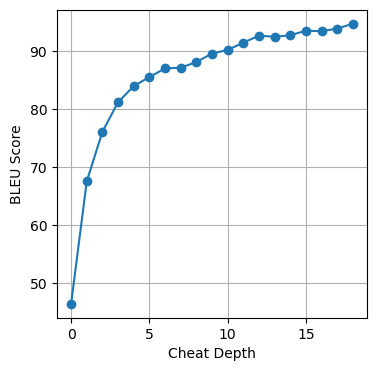

In [29]:
plt.figure(figsize=(4, 4))
plt.plot(cheat_bleu_depth_scores, marker='o') 
plt.xlabel('Cheat Depth')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.show() 